Attempting to download required NLTK resources...
NLTK 'stopwords' resource downloaded successfully or already present.
Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            5842 non-null   object
 1   true_sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB

First 5 entries of original data:
                                                text true_sentiment
0  The GeoSolutions technology will leverage Bene...       positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...       negative
2  For the last quarter of 2010 , Componenta 's n...       positive
3  According to the Finnish-Russian Chamber of Co...        neutral
4  The Swedish buyout firm has sold its remaining...        neutral

Sample sentences from original data:
The GeoSolutions technology will leverage Benefon 's GPS

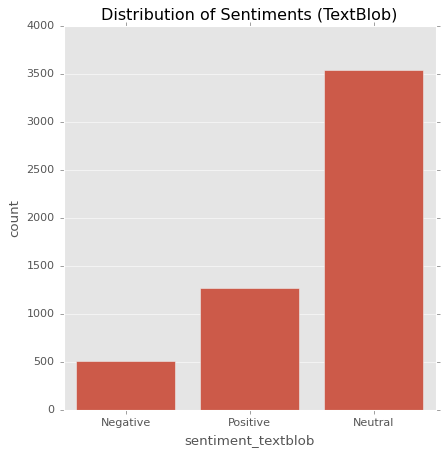

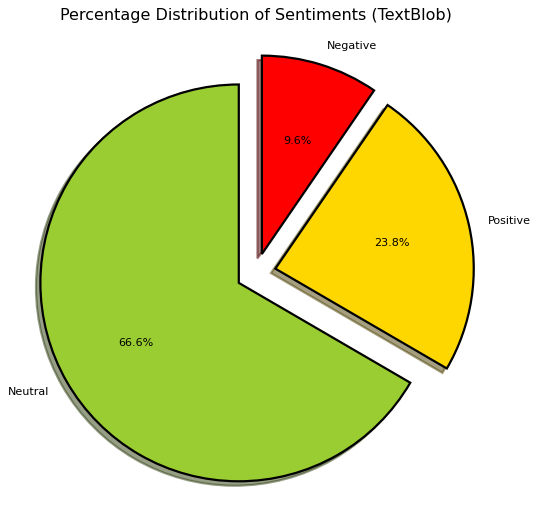


Generating word clouds...


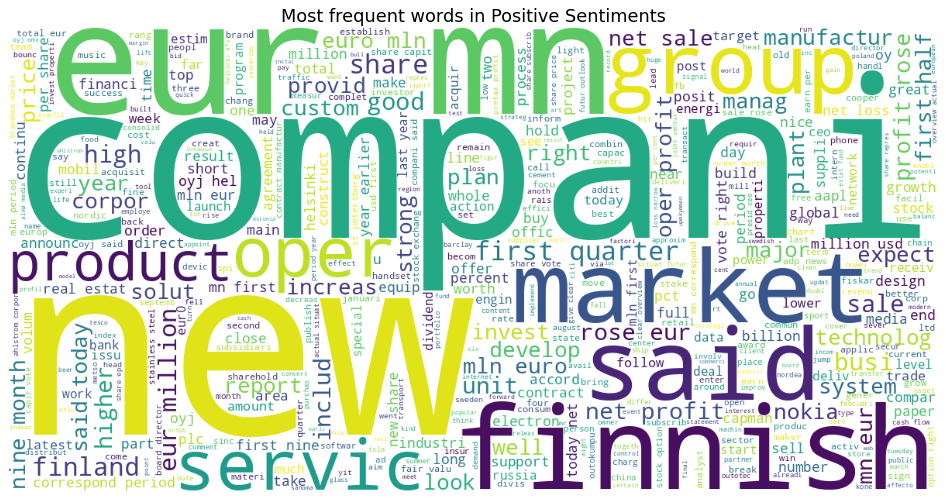

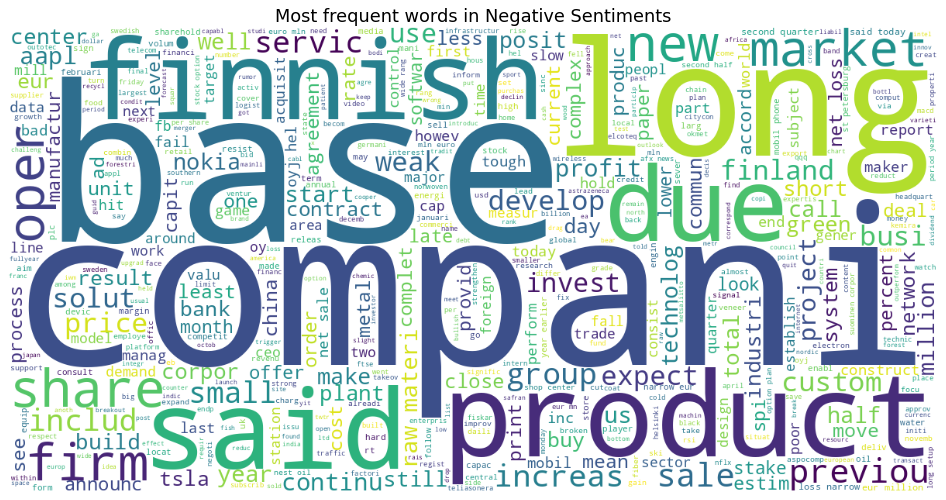

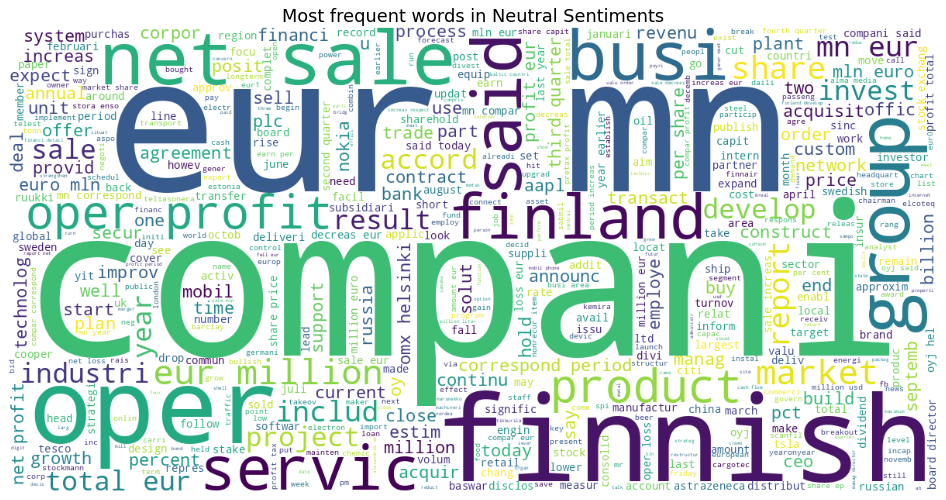


Preparing data for machine learning models...
Number of features: 54184

First 20 features:
 ['00' '00 aldata' '00 compar' '00 mn' '00 per' '000' '000 2009' '000 85'
 '000 compani' '000 correspond' '000 eur7' '000 eur900' '000 euro'
 '000 first' '000 last' '000 m3' '000 mn' '000 net' '000 number'
 '000 peopl']

Size of x_train: (4248, 54184)
Size of y_train: (4248,)
Size of x_test: (1062, 54184)
Size of y_test: (1062,)

Calculated class weights: {'negative': np.float64(3.0063694267515926), 'neutral': np.float64(0.6164562472790597), 'positive': np.float64(0.9567567567567568)}

--- Training Logistic Regression Model (with class weights) ---
Logistic Regression Test accuracy: 72.69%

Logistic Regression Confusion Matrix:
[[ 42  38  38]
 [ 22 482  70]
 [ 22 100 248]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.36      0.41       118
     neutral       0.78      0.84      0.81       574
    positive      

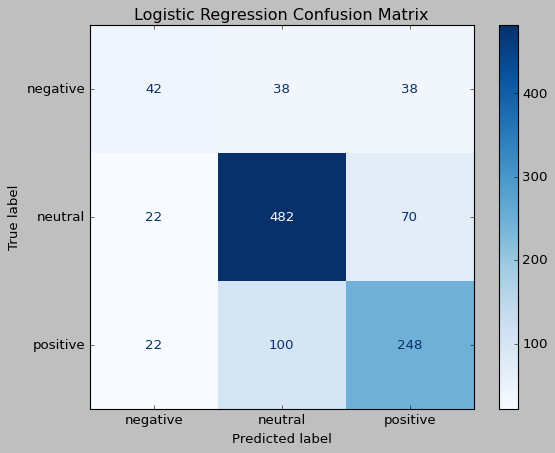


--- Hyperparameter Tuning for Logistic Regression (with class weights) ---
Best parameters for Logistic Regression: {'C': 10}
Tuned Logistic Regression Test accuracy: 74.67%

Tuned Logistic Regression Confusion Matrix:
[[ 29  47  42]
 [ 15 505  54]
 [ 15  96 259]]

Tuned Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.25      0.33       118
     neutral       0.78      0.88      0.83       574
    positive       0.73      0.70      0.71       370

    accuracy                           0.75      1062
   macro avg       0.67      0.61      0.62      1062
weighted avg       0.73      0.75      0.73      1062


--- Training LinearSVC Model (with class weights) ---
LinearSVC Test accuracy: 74.67%

LinearSVC Confusion Matrix:
[[ 27  48  43]
 [ 14 512  48]
 [ 12 104 254]]

LinearSVC Classification Report:
              precision    recall  f1-score   support

    negative       0.51      0.23      0.32       11

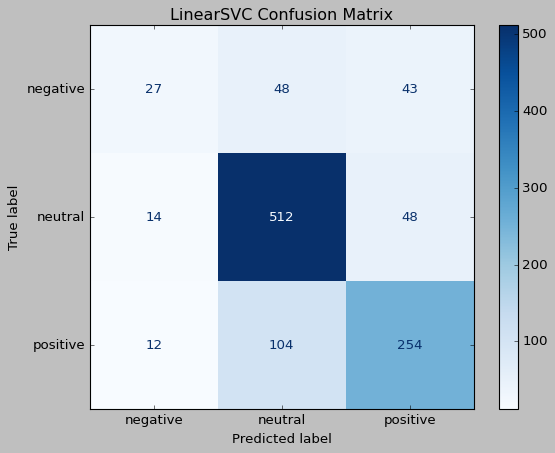


--- Hyperparameter Tuning for LinearSVC (with class weights) ---
Best parameters for LinearSVC: {'C': 1}
Tuned LinearSVC Test accuracy: 74.67%

Tuned LinearSVC Confusion Matrix:
[[ 27  48  43]
 [ 14 512  48]
 [ 12 104 254]]

Tuned LinearSVC Classification Report:
              precision    recall  f1-score   support

    negative       0.51      0.23      0.32       118
     neutral       0.77      0.89      0.83       574
    positive       0.74      0.69      0.71       370

    accuracy                           0.75      1062
   macro avg       0.67      0.60      0.62      1062
weighted avg       0.73      0.75      0.73      1062


--- Model Inference Example ---

Sample text: 'This product is absolutely amazing and exceeded all my expectations!'
Predicted sentiment (Logistic Regression): positive
Predicted sentiment (LinearSVC): positive

Sample text: 'I am extremely disappointed with the service, it was terrible.'
Predicted sentiment (Logistic Regression): neutral
Predicted se

'\n# Required installations (run in a new cell in Colab/Jupyter if possible):\n# !pip install transformers torch\n# or if using tensorflow:\n# !pip install transformers tensorflow\n\nfrom transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments\nfrom sklearn.preprocessing import LabelEncoder\nfrom torch.nn.functional import softmax # or tf.nn.softmax if using TensorFlow\nimport torch # or import tensorflow as tf\n\n# 1. Prepare Data for Transformer\n# Assuming text_df and true_sentiment are already available from above\n# Convert labels to numerical format for the model\nle = LabelEncoder()\ntext_df[\'labels\'] = le.fit_transform(text_df[\'true_sentiment\'])\nlabel_mapping = dict(zip(le.classes_, le.transform(le.classes_)))\nprint(f"Label mapping for transformer: {label_mapping}")\n\n# Split data (using the original text data for transformers)\ntrain_texts, val_texts, train_labels, val_labels = train_test_split(\n    text_df[\'text\']

In [10]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from collections import Counter

# --- NLTK Setup ---
import nltk
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Download required resources (stopwords are still needed)
print("Attempting to download required NLTK resources...")
try:
    # 'punkt' download is still present for completeness, but word_tokenize will be avoided
    # nltk.download('punkt', quiet=True) # Not strictly needed if word_tokenize is replaced
    nltk.download('stopwords', quiet=True)
    print("NLTK 'stopwords' resource downloaded successfully or already present.")
except Exception as e:
    print(f"Error during NLTK download: {e}")

# Removed word_tokenize import as it will be replaced
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud
# MODIFIED: Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC

# Import for class weighting
from sklearn.utils import class_weight

# Load dataset
df = pd.read_csv('data.csv')

# Data exploration and preprocessing setup
text_df = df[['Sentence', 'Sentiment']].copy()
# Corrected the column name here. It should be 'Sentiment' from the CSV, not 'true_sentiment'
text_df.rename(columns={'Sentence': 'text', 'Sentiment': 'true_sentiment'}, inplace=True)

print("Original Data Info:")
text_df.info()
print("\nFirst 5 entries of original data:")
print(text_df.head())
print("\nSample sentences from original data:")
for i in range(5):
    print(text_df['text'].iloc[i], "\n")


# --- Text Preprocessing Functions ---
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # MODIFIED: Using text.split() instead of word_tokenize to bypass 'punkt_tab' error
    text_tokens = text.split()
    filtered_text = [w for w in text_tokens if w not in stop_words]
    return " ".join(filtered_text)

stemmer = PorterStemmer()
def stemming(text_string):
    words = text_string.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)


# Apply preprocessing
print("\nApplying data processing...")
text_df['text'] = text_df['text'].apply(data_processing)
text_df = text_df.drop_duplicates('text')
print("Applying stemming...")
text_df['text'] = text_df['text'].apply(stemming)


print("\nProcessed Data Info:")
text_df.info()
print("\nFirst 5 entries of processed data:")
print(text_df.head())
print("\nSample sentences from processed data:")
for i in range(5):
    print(text_df['text'].iloc[i], "\n")


# --- Sentiment Analysis with TextBlob (Retained for comparison/baseline) ---
def polarity(text):
    return TextBlob(text).sentiment.polarity

text_df['polarity'] = text_df['text'].apply(polarity)

def sentiment(label):
    if label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"

text_df['sentiment_textblob'] = text_df['polarity'].apply(sentiment) # Renamed for clarity

print("\nData with TextBlob sentiments:")
print(text_df.head())


# --- Sentiment Distribution Visualizations ---
print("\nGenerating sentiment distribution plots...")
fig = plt.figure(figsize=(6,6))
sns.countplot(x='sentiment_textblob', data=text_df)
plt.title('Distribution of Sentiments (TextBlob)')
plt.show()

fig = plt.figure(figsize=(8,8))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment_textblob'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
           startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Percentage Distribution of Sentiments (TextBlob)')
plt.show()


# --- Word Clouds ---
print("\nGenerating word clouds...")
for label, title in [('Positive', 'Positive Sentiments'),
                      ('Negative', 'Negative Sentiments'),
                      ('Neutral', 'Neutral Sentiments')]:
    tweets = text_df[text_df.sentiment_textblob == label] # Use sentiment_textblob
    text_combined = ' '.join(tweets['text'])
    plt.figure(figsize=(15,10), facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1200, height=600, background_color='white').generate(text_combined)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Most frequent words in {title}', fontsize=16)
    plt.show()


# --- Feature Extraction and Model Training ---
print("\nPreparing data for machine learning models...")
# MODIFIED: Using TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,2)).fit(text_df['text'])
feature_names = vect.get_feature_names_out()
print(f"Number of features: {len(feature_names)}\n")
print(f"First 20 features:\n {feature_names[:20]}\n")

X = text_df['text']
Y = text_df['true_sentiment'] # This is the ground truth sentiment from the dataset

X_vectorized = vect.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_vectorized, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Size of x_train: {x_train.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of x_test: {x_test.shape}")
print(f"Size of y_test: {y_test.shape}")

# ENHANCEMENT: Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print(f"\nCalculated class weights: {class_weights_dict}")

# --- Logistic Regression ---
print("\n--- Training Logistic Regression Model (with class weights) ---")
# ENHANCEMENT: Pass class_weight to the model
logreg = LogisticRegression(max_iter=1000, class_weight=class_weights_dict)
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print(f"Logistic Regression Test accuracy: {logreg_acc*100:.2f}%")

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, logreg_pred))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logreg_pred))

style.use('classic')
cm_logreg = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg.classes_)
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# GridSearchCV for Logistic Regression
print("\n--- Hyperparameter Tuning for Logistic Regression (with class weights) ---")
# ENHANCEMENT: Slightly expanded C range for tuning
param_grid_logreg = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000, class_weight=class_weights_dict), param_grid_logreg, cv=5)
grid_logreg.fit(x_train, y_train)

print("Best parameters for Logistic Regression:", grid_logreg.best_params_)
y_pred_logreg_tuned = grid_logreg.predict(x_test)
logreg_acc_tuned = accuracy_score(y_pred_logreg_tuned, y_test)
print(f"Tuned Logistic Regression Test accuracy: {logreg_acc_tuned*100:.2f}%")

print("\nTuned Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg_tuned))
print("\nTuned Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg_tuned))

# --- LinearSVC Model ---
print("\n--- Training LinearSVC Model (with class weights) ---")
# ENHANCEMENT: Pass class_weight to the model
SVCmodel = LinearSVC(max_iter=2000, class_weight=class_weights_dict)
SVCmodel.fit(x_train, y_train)
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print(f"LinearSVC Test accuracy: {svc_acc*100:.2f}%")

print("\nLinearSVC Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred))
print("\nLinearSVC Classification Report:")
print(classification_report(y_test, svc_pred))

cm_svc = confusion_matrix(y_test, svc_pred, labels=SVCmodel.classes_)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=SVCmodel.classes_)
disp_svc.plot(cmap=plt.cm.Blues)
plt.title('LinearSVC Confusion Matrix')
plt.show()

# GridSearchCV for LinearSVC
print("\n--- Hyperparameter Tuning for LinearSVC (with class weights) ---")
# ENHANCEMENT: Slightly expanded C range for tuning
param_grid_svc = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_svc = GridSearchCV(LinearSVC(max_iter=2000, class_weight=class_weights_dict), param_grid_svc, cv=5)
grid_svc.fit(x_train, y_train)

print("Best parameters for LinearSVC:", grid_svc.best_params_)
y_pred_svc_tuned = grid_svc.predict(x_test)
svc_acc_tuned = accuracy_score(y_pred_svc_tuned, y_test)
print(f"Tuned LinearSVC Test accuracy: {svc_acc_tuned*100:.2f}%")

print("\nTuned LinearSVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc_tuned))
print("\nTuned LinearSVC Classification Report:")
print(classification_report(y_test, y_pred_svc_tuned))


# --- ENHANCEMENT: Simple Model Inference with custom input ---
print("\n--- Model Inference Example ---")
def predict_sentiment(text_input, vectorizer, model):
    processed_text = data_processing(text_input)
    stemmed_text = stemming(processed_text)
    vectorized_text = vectorizer.transform([stemmed_text])
    prediction = model.predict(vectorized_text)
    return prediction[0]

sample_text_positive = "This product is absolutely amazing and exceeded all my expectations!"
sample_text_negative = "I am extremely disappointed with the service, it was terrible."
sample_text_neutral = "The delivery arrived on time, nothing special to note."

print(f"\nSample text: '{sample_text_positive}'")
print(f"Predicted sentiment (Logistic Regression): {predict_sentiment(sample_text_positive, vect, grid_logreg.best_estimator_)}")
print(f"Predicted sentiment (LinearSVC): {predict_sentiment(sample_text_positive, vect, grid_svc.best_estimator_)}")

print(f"\nSample text: '{sample_text_negative}'")
print(f"Predicted sentiment (Logistic Regression): {predict_sentiment(sample_text_negative, vect, grid_logreg.best_estimator_)}")
print(f"Predicted sentiment (LinearSVC): {predict_sentiment(sample_text_negative, vect, grid_svc.best_estimator_)}")

print(f"\nSample text: '{sample_text_neutral}'")
print(f"Predicted sentiment (Logistic Regression): {predict_sentiment(sample_text_neutral, vect, grid_logreg.best_estimator_)}")
print(f"Predicted sentiment (LinearSVC): {predict_sentiment(sample_text_neutral, vect, grid_svc.best_estimator_)}")


# --- CONCEPTUAL ENHANCEMENT: Advanced Sentiment Analysis with Transformer Model ---
# This section provides the conceptual code. To run this, you would need
# to install 'transformers' and a deep learning framework like 'torch' or 'tensorflow'.
# This demonstrates knowledge of state-of-the-art NLP for interviews.

print("\n--- Advanced Sentiment Analysis with Transformer Model (Conceptual) ---")
print("This section outlines how you would use a pre-trained transformer model (e.g., DistilBERT).")
print("To run this, you would need to install 'transformers' and 'torch' or 'tensorflow'.")
print("This part is conceptual due to environment limitations.\n")

"""
# Required installations (run in a new cell in Colab/Jupyter if possible):
# !pip install transformers torch
# or if using tensorflow:
# !pip install transformers tensorflow

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from torch.nn.functional import softmax # or tf.nn.softmax if using TensorFlow
import torch # or import tensorflow as tf

# 1. Prepare Data for Transformer
# Assuming text_df and true_sentiment are already available from above
# Convert labels to numerical format for the model
le = LabelEncoder()
text_df['labels'] = le.fit_transform(text_df['true_sentiment'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Label mapping for transformer: {label_mapping}")

# Split data (using the original text data for transformers)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    text_df['text'].tolist(),
    text_df['labels'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=text_df['labels'].tolist()
)

# 2. Tokenize Data
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Create a PyTorch dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# 3. Load Pre-trained Model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_) # Number of sentiment classes
)

# 4. Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save checkpoint every epoch
    load_best_model_at_end=True,     # Load the best model when training ends
    metric_for_best_model="accuracy",# Metric to monitor for best model
)

# 5. Define Metrics (optional, but good practice)
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted') # Use 'weighted' for multi-class
    return {"accuracy": acc, "f1_weighted": f1}

# 6. Initialize and Train Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
print("\n--- Transformer Model Evaluation ---")
eval_results = trainer.evaluate()
print(eval_results)

# Example Prediction with trained transformer model
def predict_with_transformer(text, tokenizer, model, label_encoder):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors='pt')
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = softmax(logits, dim=1)
    predicted_class_id = torch.argmax(probabilities, dim=1).item()
    predicted_sentiment = label_encoder.inverse_transform([predicted_class_id])[0]
    return predicted_sentiment, probabilities.detach().numpy()

# Test with a sample sentence (after training)
# print(f"Sample text: '{sample_text_positive}'")
# sentiment_pred, probs = predict_with_transformer(sample_text_positive, tokenizer, model, le)
# print(f"Predicted Sentiment (Transformer): {sentiment_pred} with probabilities: {probs}")
"""

In [1]:
import nltk
print("Attempting to download 'punkt'...")
try:
    nltk.download('punkt', quiet=True)
    print("'punkt' downloaded successfully or already present.")
except Exception as e:
    print(f"Error downloading 'punkt': {e}")

print("\nAttempting to download 'stopwords'...")
try:
    nltk.download('stopwords', quiet=True)
    print("'stopwords' downloaded successfully or already present.")
except Exception as e:
    print(f"Error downloading 'stopwords': {e}")

# You might also want to explicitly import after download, though it should happen automatically
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

Attempting to download 'punkt'...
'punkt' downloaded successfully or already present.

Attempting to download 'stopwords'...
'stopwords' downloaded successfully or already present.


In [3]:
import nltk
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [4]:
import nltk
print("Attempting to download 'punkt'...")
try:
    # This will download 'punkt' which includes 'punkt_tab'
    nltk.download('punkt')
    print("'punkt' downloaded successfully or already present.")
except Exception as e:
    print(f"Error downloading 'punkt': {e}")

print("\nAttempting to download 'stopwords'...")
try:
    nltk.download('stopwords')
    print("'stopwords' downloaded successfully or already present.")
except Exception as e:
    print(f"Error downloading 'stopwords': {e}")

Attempting to download 'punkt'...
'punkt' downloaded successfully or already present.

Attempting to download 'stopwords'...
'stopwords' downloaded successfully or already present.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
